#### 1. Data

In [1]:
import pandas as pd
import bz2
def get_data_from_file_bz2(filepath):
    labels = []
    texts = []
    for line in bz2.BZ2File(filepath):
        line = line.decode("utf-8")
        #       012345678901
        # line: __label__2 Stuning even for the non-gamer...
        labels.append(int(line[9]) - 1)
        texts.append(line[11:].strip())
    df = pd.DataFrame({'label': labels, 'text': texts})
    return df

In [13]:
import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from joblib import Parallel, delayed
import multiprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Stopwords and lemmatizer initialization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def text_cleaning(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove URLs
    text = re.sub(r'(?:https?:\/\/(?:www\.|(?!www))|www\.)[\w\-\.\+/?=&#@:%~]+', 'URL', text)
    # Remove punctuation and special characters
    text = re.sub(r'[\W_]+', ' ', text)
    # Remove stopwords
    tokens = [word for word in text.split() if word not in stop_words]
    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

def get_data_from_file(filepath):
    labels = []
    texts = []
    with open(file=filepath, mode='r', encoding='utf-8') as file:
        for line in file.readlines():
            #       012345678901
            # line: __label__2 Stuning even for the non-gamer...
            labels.append(int(line[9]))
            text = line[11:].strip()
            texts.append(text_cleaning(text))
    #num_cores = multiprocessing.cpu_count()
    #texts = Parallel(n_jobs=num_cores)(delayed(text_cleaning)(text) for text in texts)
    df = pd.DataFrame({'label': labels, 'text': texts})
    return df

# Load train data file
train_filepath = 'train.3270.txt'
df_train = get_data_from_file(train_filepath)

# Load test data file
test_filepath = 'test.135.txt'
df_test = get_data_from_file(test_filepath)

X = df_train['text']
y = df_train['label']
X_test = df_test['text']
y_test = df_test['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

del train_filepath, test_filepath, stopwords, df_train, df_test, X, y

#############################################################################################

# Initialize the Tokenizer, Limit the vocabulary size to 5000
vocab_size = 5000
tokenizer = Tokenizer(num_words=vocab_size)

# Fit the Tokenizer on the training data
tokenizer.fit_on_texts(X_train)

# Convert the text data to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Determine the maximum length of sequences in X_train_seq
max_len = max(len(seq) for seq in X_train_seq)

# Pad the sequences to ensure they all have the same length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Convert y_train, y_val, y_test to binary (0/1)
y_train_bin = y_train.apply(lambda x: 1 if x == 2 else 0)
y_val_bin = y_val.apply(lambda x: 1 if x == 2 else 0)
y_test_bin = y_test.apply(lambda x: 1 if x == 2 else 0)

# Convert the padded sequences and labels to TensorFlow Datasets
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train_padded, y_train_bin))
# val_dataset = tf.data.Dataset.from_tensor_slices((X_val_padded, y_val_bin))
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test_padded, y_test_bin))

del X_train_seq, X_val_seq, X_test_seq, X_test, y_test, X_train, X_val, y_train, y_val

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HUYNGUYEN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HUYNGUYEN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### 2. Model

In [26]:
# Set graph-level seed for reproducibility
#tf.random.set_seed(42)

In [20]:
# Model Definition
class SentimentModel(tf.Module):
    def __init__(self, vocab_size, embedding_dim, units, batch_size=32):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.units = units
        self.batch_size = batch_size
        self.embedding = tf.Variable(tf.random.normal([vocab_size, embedding_dim]), name='embedding')
        self.dense_1 = tf.Variable(tf.random.normal([embedding_dim, units]), name='dense_1')
        self.dense_2 = tf.Variable(tf.random.normal([units, 1]), name='dense_2')
        self.bias_1 = tf.Variable(tf.zeros([units]), name='bias_1')
        self.bias_2 = tf.Variable(tf.zeros([1]), name='bias_2')
        self.optimizer = None
        self.loss_fn = None
        self.train_loss = []
        self.train_accuracy = []
        self.val_loss = []
        self.val_accuracy = []

    def __call__(self, x, training=False):
        x = tf.nn.embedding_lookup(self.embedding, x)
        x = tf.reduce_mean(x, axis=1)
        x = tf.nn.relu(tf.matmul(x, self.dense_1) + self.bias_1)
        if training:
            x = tf.nn.dropout(x, rate=0.5, name='dropout')
        x = tf.sigmoid(tf.matmul(x, self.dense_2) + self.bias_2)
        return x

    def compile(self, optimizer, loss, learning_rate=0.001):
        self.optimizer = tf.optimizers.Adam(learning_rate=learning_rate) if optimizer == 'adam' else optimizer
        self.loss_fn = tf.losses.BinaryCrossentropy() if loss == 'binary_crossentropy' else loss

    @tf.function
    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            predictions = self(x, training=True)
            loss = self.loss_fn(y, predictions)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return loss, predictions

    @tf.function
    def val_step(self, x, y):
        predictions = self(x, training=False)
        v_loss = self.loss_fn(y, predictions)
        return v_loss, predictions

    def fit(self, X_train, y_train, epochs, validation_data):
        X_val, y_val = validation_data
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=len(X_train)).batch(self.batch_size)
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(self.batch_size)
        
        for epoch in range(epochs):
            epoch_train_loss = tf.keras.metrics.Mean()
            epoch_train_accuracy = tf.keras.metrics.BinaryAccuracy()
            epoch_val_loss = tf.keras.metrics.Mean()
            epoch_val_accuracy = tf.keras.metrics.BinaryAccuracy()
            
            # Training loop
            for x_batch, y_batch in train_dataset:
                train_loss, predictions = self.train_step(x_batch, y_batch)
                epoch_train_loss(train_loss)
                epoch_train_accuracy(y_batch, predictions)
            
            # Validation loop
            for x_val_batch, y_val_batch in val_dataset:
                val_loss, predictions = self.val_step(x_val_batch, y_val_batch)
                epoch_val_loss(val_loss)
                epoch_val_accuracy(y_val_batch, predictions)
            
            # Store epoch metrics
            self.train_loss.append(epoch_train_loss.result())
            self.train_accuracy.append(epoch_train_accuracy.result())
            self.val_loss.append(epoch_val_loss.result())
            self.val_accuracy.append(epoch_val_accuracy.result())
            
            # Print epoch metrics
            print(
                f'Epoch {epoch + 1}, '
                f'Loss: {epoch_train_loss.result():.4f}, '
                f'Accuracy: {epoch_train_accuracy.result() * 100:.2f}%, '
                f'Val Loss: {epoch_val_loss.result():.4f}, '
                f'Val Accuracy: {epoch_val_accuracy.result() * 100:.2f}%'
            )

    def evaluate(self, X_test, y_test):
        loss_metric = tf.metrics.Mean()
        accuracy_metric = tf.metrics.BinaryAccuracy()
        dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(self.batch_size)
        for x_batch, y_batch in dataset:
            predictions = self(x_batch, training=False)
            loss_metric(self.loss_fn(y_batch, predictions))
            accuracy_metric(y_batch, predictions)
        return loss_metric.result().numpy(), accuracy_metric.result().numpy()

    def predict_texts(self, texts_padded_sequences=[]):
        # Create dataset from padded sequences
        dataset = tf.data.Dataset.from_tensor_slices(texts_padded_sequences).batch(self.batch_size)
        
        # Predict on batches
        predictions = []
        predictions_bin = []
        for batch in dataset:
            batch_predictions = self(batch, training=False)
            predictions.extend(batch_predictions.numpy().flatten())
            binary_predictions = tf.where(batch_predictions >= 0.5, 1, 0)
            predictions_bin.extend(binary_predictions.numpy().flatten())
        
        return predictions, predictions_bin

    def predict(self, X_data):
        dataset = tf.data.Dataset.from_tensor_slices(X_data).batch(self.batch_size)
        predictions = []
        for batch in dataset:
            batch_predictions = self(batch, training=False)
            binary_predictions = tf.where(batch_predictions >= 0.5, 1, 0)
            predictions.extend(binary_predictions.numpy().flatten())
        return predictions

    def plot_metrics(self):
        epochs_range = range(1, len(self.train_loss) + 1)
        plt.figure(figsize=(12, 4))

        # Plotting training loss vs validation loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, self.train_loss, label='Training Loss')
        plt.plot(epochs_range, self.val_loss, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plotting training accuracy vs validation accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, self.train_accuracy, label='Training Accuracy')
        plt.plot(epochs_range, self.val_accuracy, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [21]:
# Hyperparameters
embedding_dim = max_len
units = 10
learning_rate = 0.001
epochs = 15
batch_size = 32

# Instantiate and compile the model
model = SentimentModel(vocab_size=vocab_size + 1, embedding_dim=embedding_dim, units=units, batch_size=batch_size)
model.compile(optimizer='adam', loss='binary_crossentropy', learning_rate=learning_rate)

# Train the model
model.fit(X_train_padded, y_train_bin, epochs=epochs, validation_data=(X_val_padded, y_val_bin))

# Evaluation on validation set
val_loss, val_accuracy = model.evaluate(X_val_padded, y_val_bin)
print(f"Val Loss: {val_loss}")
print(f"Val Accuracy: {val_accuracy * 100:.2f}%")

# Evaluation on test set
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test_bin)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1, Loss: 2.0263, Accuracy: 48.97%, Val Loss: 0.7619, Val Accuracy: 48.78%
Epoch 2, Loss: 0.7542, Accuracy: 51.49%, Val Loss: 0.6957, Val Accuracy: 51.68%
Epoch 3, Loss: 0.7010, Accuracy: 53.86%, Val Loss: 0.6888, Val Accuracy: 53.52%
Epoch 4, Loss: 0.6888, Accuracy: 54.28%, Val Loss: 0.6858, Val Accuracy: 53.52%
Epoch 5, Loss: 0.6808, Accuracy: 56.23%, Val Loss: 0.6854, Val Accuracy: 54.13%
Epoch 6, Loss: 0.6653, Accuracy: 56.69%, Val Loss: 0.6826, Val Accuracy: 55.35%
Epoch 7, Loss: 0.6616, Accuracy: 56.69%, Val Loss: 0.6750, Val Accuracy: 53.82%
Epoch 8, Loss: 0.6500, Accuracy: 57.45%, Val Loss: 0.6704, Val Accuracy: 55.35%
Epoch 9, Loss: 0.6383, Accuracy: 60.24%, Val Loss: 0.6607, Val Accuracy: 58.10%
Epoch 10, Loss: 0.6261, Accuracy: 60.97%, Val Loss: 0.6568, Val Accuracy: 58.56%
Epoch 11, Loss: 0.6210, Accuracy: 62.27%, Val Loss: 0.6495, Val Accuracy: 63.76%
Epoch 12, Loss: 0.6133, Accuracy: 64.56%, Val Loss: 0.6358, Val Accuracy: 65.60%
Epoch 13, Loss: 0.6027, Accuracy: 63.

In [27]:
# Example usage of predict method
new_texts = [
    "Great book for travelling Europe: I currently live in Europe, and this is the book I recommend for my visitors. It covers many countries, colour pictures, and is a nice starter for before you go, and once you are there.", # __label__2 
    "Not!: If you want to listen to El Duke , then it is better if you have access to his shower,this is not him, it is a gimmick,very well orchestrated.", # __label__1
    "A complete Bust: This game requires quicktime 5.0 to work...if you have a better version of quicktime (I have 7.5), it will ask you to install the quicktime available on the CD...if you click no, it will not let you play. So, I begrudgingly clicked yes on the third try, and it installed quicktime 5, THEN it tells me to please install the quicktime available on the disc. It KEPT telling me that, even after I uninstalled my version of quicktime 7.5, and reinstalled Barbie Rapunzel and quicktime 5. Very frustrating, and the game absolutely will not work for me. It keeps telling me over and over, to install quicktime 5, tho I've been through the installation process repeatedly. It is NOT my \"operating system limitations\". This is a brand new computer...merely weeks old with all the state of the art contraptions." # __label__1
]
texts = [text_cleaning(text) for text in new_texts]
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

predictions, predictions_bin = model.predict_texts(padded_sequences)
print("Predictions:", predictions)
print("Predictions Label:", predictions_bin)

Predictions: [0.62593573, 0.44970042, 0.16457674]
Predictions Label: [1, 0, 0]


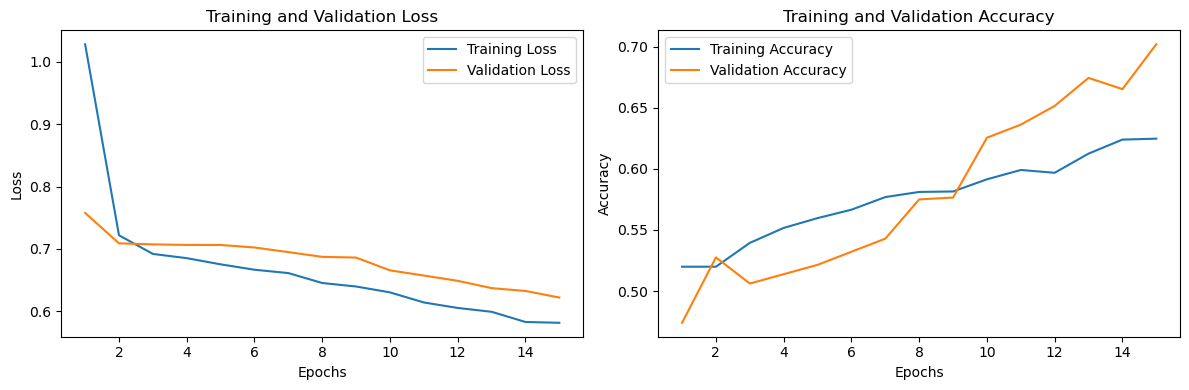

In [18]:
model.plot_metrics()

In [23]:
y_val_pred = model.predict(X_val_padded)

In [26]:
report = classification_report(y_val_bin, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.68      0.81      0.74       342
           1       0.74      0.58      0.65       312

    accuracy                           0.70       654
   macro avg       0.71      0.70      0.70       654
weighted avg       0.71      0.70      0.70       654



#### 3. Backup

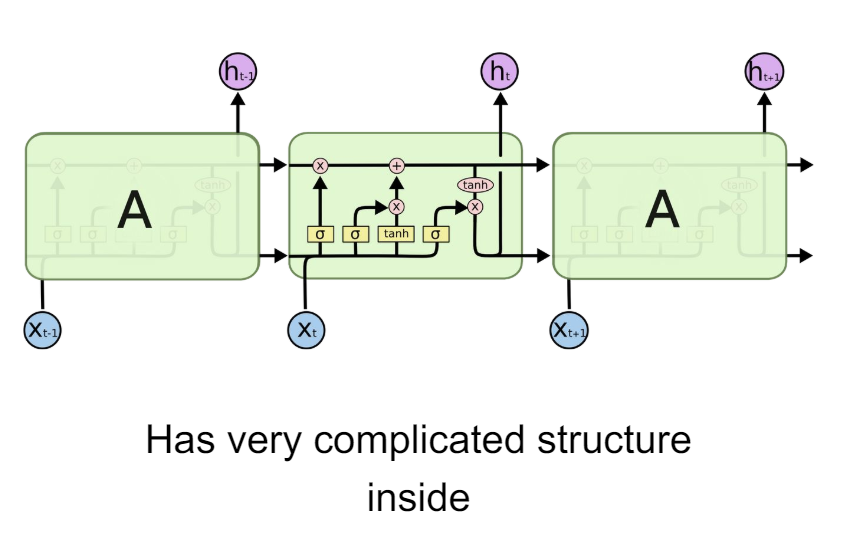

In [ ]:
import tensorflow as tf
from sklearn.metrics import classification_report

class SentimentModel(tf.Module):
    def __init__(self, vocab_size, embedding_dim, lstm_units, dropout_rate=0.5):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        
        # Embedding layer
        self.embedding = tf.Variable(tf.random.normal([vocab_size, embedding_dim]), name='embedding')
        
        # LSTM layers
        self.lstm_1 = tf.Variable(tf.random.normal([embedding_dim, lstm_units]), name='lstm_1')
        self.lstm_2 = tf.Variable(tf.random.normal([lstm_units, lstm_units]), name='lstm_2')
        
        # Dense layers for classification
        self.dense_1 = tf.Variable(tf.random.normal([lstm_units, 64]), name='dense_1')
        self.dense_2 = tf.Variable(tf.random.normal([64, 1]), name='dense_2')
        
        # Bias terms
        self.bias_lstm_1 = tf.Variable(tf.zeros([lstm_units]), name='bias_lstm_1')
        self.bias_lstm_2 = tf.Variable(tf.zeros([lstm_units]), name='bias_lstm_2')
        self.bias_dense_1 = tf.Variable(tf.zeros([64]), name='bias_dense_1')
        self.bias_dense_2 = tf.Variable(tf.zeros([1]), name='bias_dense_2')

    def lstm_cell(self, x, h_prev, c_prev, lstm_weights, bias):
        z = tf.matmul(x, lstm_weights) + tf.expand_dims(bias, axis=0)
        z_concat = tf.concat([z, h_prev], axis=1)
        i, f, o, g = tf.split(z_concat, 4, axis=1)
        i = tf.sigmoid(i)
        f = tf.sigmoid(f)
        o = tf.sigmoid(o)
        g = tf.tanh(g)
        c = f * c_prev + i * g
        h = o * tf.tanh(c)
        return h, c

    @tf.function
    def call(self, x, training=False):
        x = tf.nn.embedding_lookup(self.embedding, x)
        batch_size = tf.shape(x)[0]
        h_prev = tf.zeros([batch_size, self.lstm_units])
        c_prev = tf.zeros([batch_size, self.lstm_units])
        
        for i in range(tf.shape(x)[1]):
            h_prev, c_prev = self.lstm_cell(x[:, i, :], h_prev, c_prev, self.lstm_1, self.bias_lstm_1)
            h_prev, c_prev = self.lstm_cell(h_prev, h_prev, c_prev, self.lstm_2, self.bias_lstm_2)
        
        x = tf.nn.relu(tf.matmul(h_prev, self.dense_1) + self.bias_dense_1)
        if training:
            x = tf.nn.dropout(x, rate=self.dropout_rate)
        x = tf.sigmoid(tf.matmul(x, self.dense_2) + self.bias_dense_2)
        return x

    def compile(self, optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']):
        self.optimizer = optimizer

    @tf.function
    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            predictions = self(x, training=True)
            loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y, predictions))
        gradients = tape.gradient(loss, self.trainable_variables())
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables()))
        return loss, predictions

    @tf.function
    def val_step(self, x, y):
        predictions = self(x, training=False)
        loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y, predictions))
        return loss, predictions

    def fit(self, X_train, y_train, epochs, batch_size, validation_data):
        X_val, y_val = validation_data
        
        for epoch in range(epochs):
            epoch_train_loss = tf.keras.metrics.Mean()
            epoch_train_accuracy = tf.keras.metrics.BinaryAccuracy()
            epoch_val_loss = tf.keras.metrics.Mean()
            epoch_val_accuracy = tf.keras.metrics.BinaryAccuracy()
            
            # Training loop
            for i in range(0, len(X_train), batch_size):
                x_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                train_loss, predictions = self.train_step(x_batch, y_batch)
                epoch_train_loss(train_loss)
                epoch_train_accuracy(y_batch, predictions)
            
            # Validation loop
            for i in range(0, len(X_val), batch_size):
                x_val_batch = X_val[i:i+batch_size]
                y_val_batch = y_val[i:i+batch_size]
                val_loss, predictions = self.val_step(x_val_batch, y_val_batch)
                epoch_val_loss(val_loss)
                epoch_val_accuracy(y_val_batch, predictions)
            
            # Print epoch metrics
            print(
                f'Epoch {epoch + 1}, '
                f'Loss: {epoch_train_loss.result():.4f}, '
                f'Accuracy: {epoch_train_accuracy.result() * 100:.2f}%, '
                f'Val Loss: {epoch_val_loss.result():.4f}, '
                f'Val Accuracy: {epoch_val_accuracy.result() * 100:.2f}%'
            )

    def evaluate(self, X_test, y_test, batch_size):
        loss_metric = tf.keras.metrics.Mean()
        accuracy_metric = tf.keras.metrics.BinaryAccuracy()
        
        for i in range(0, len(X_test), batch_size):
            x_batch = X_test[i:i+batch_size]
            y_batch = y_test[i:i+batch_size]
            predictions = self(x_batch, training=False)
            loss_metric(tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_batch, predictions)))
            accuracy_metric(y_batch, predictions)
        
        return loss_metric.result().numpy(), accuracy_metric.result().numpy()

    def predict_texts(self, texts, tokenizer, max_len):
        sequences = tokenizer.texts_to_sequences(texts)
        padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, padding='post')
        predictions = self(padded_sequences, training=False)
        binary_predictions = tf.where(predictions >= 0.5, 1, 0)
        return binary_predictions.numpy().flatten()

    def predict(self, X_data, batch_size):
        predictions = []
        for i in range(0, len(X_data), batch_size):
            x_batch = X_data[i:i+batch_size]
            batch_predictions = self(x_batch, training=False)
            binary_predictions = tf.where(batch_predictions >= 0.5, 1, 0)
            predictions.extend(binary_predictions.numpy().flatten())
        return predictions

    def classification_report(self, X_test, y_test, batch_size):
        predictions = self.predict(X_test, batch_size)
        report = classification_report(y_test, predictions)
        return report
